In [23]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from dateutil.parser import parse
from datetime import timedelta
from tqdm import tqdm

### 데이터 불러오기

In [24]:
data = pd.read_csv("data/NORMAL+EDLC(5%-(40-4-10)_4).csv").iloc[:, :3]

### 기준 전압 인덱스 구하기

In [33]:
comm_A = np.where((data['Current(A)'] < 0.0500) & (data['Current(A)'] > 0.030)) #통신 전류 -> 0.040

In [34]:
comm__ = np.array(comm_A[0]) #comm_A[0]의 type이 tuple이기 때문에
comm__ = np.array(comm__)

0.080로 5% 소모하는 구간에 0.040 전류가 끼어있음

In [35]:
comm__ = np.delete(comm__, np.where(comm__ == 590501))

#### 통신 전류 시작 인덱스 하나만

In [36]:
#첫 번째 인덱스는 넣어두고 시작
comm_ = np.array(comm__[0])

for idx in range(comm__.shape[0]-1):
    #현재 값+1과 다음값이 같지 않으면 연속된 숫자가 아니라는 것으로 추가함
    if comm__[idx]+1 != comm__[idx+1]:
        comm_ = np.append(comm_, comm__[idx+1])

In [45]:
comm_

array([ 75789,  75812,  75835,  75860, 151461, 151483, 151506, 151530,
       226331, 226353, 226377, 226400, 300432, 300454, 300478, 300500,
       373825, 373847, 373869, 373892, 446835, 446858, 446880, 446902,
       519373, 519395, 519418, 519440, 591051, 591072, 591094, 591117],
      dtype=int64)

In [68]:
comm = np.delete(comm, np.where(comm == 591117))

#### 기준 전압은 통신 시작 전류 인덱스 바로 전

In [69]:
t_crit = comm - 1

#### 인덱스 조정: 전압이 떨어지는 순간부터

In [70]:
ref = np.array([], dtype=int)

for t in tqdm(t_crit):
    tmp = t  #tmp는 >0.020 이전의 전압 인덱스
    
    for i in range(1, 5): #4번 loop
        #전압(+): t < t-1
        if (data['Voltage(V)'][tmp] < data['Voltage(V)'][t-i]):
            #t-1 > t-2 => 인덱스 변경: t-i
            if data['Voltage(V)'][t-i] >= data['Voltage(V)'][t-i-1]: #이전 이전의 전압이 더 작으면
                tmp = t-i
                break
            else:
                tmp = t- i
        #전압 (-), 전류 (+) => 인덱스 변경: t-i
        elif (data['Voltage(V)'][tmp] > data['Voltage(V)'][t-i]) and (data['Current(A)'][tmp] < data['Current(A)'][t-i]) and (data['Current(A)'][tmp] != 0.0000) and (data['Current(A)'][t-i] > 0.020):
            tmp = t-i
        #전압(-) => 인덱스 유지
        elif data['Voltage(V)'][tmp] > data['Voltage(V)'][t-i]:
            break
        #전압이 같음: t == t-1
        elif data['Voltage(V)'][tmp] == data['Voltage(V)'][t-i]:
            #t-1 < t-2 => 인덱스 변경: t-i-1
            if data['Voltage(V)'][t-i] < data['Voltage(V)'][t-i-1]:
                tmp = t-i-1
                break
            
    ref = np.append(ref, tmp)
            
ref = np.unique(ref) #중복 값 제거

100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 8004.40it/s]



### 전압 회복 시간, 회복률, 전압을 확인하기 위함
- recovery_time [[통신 전, crit_time]]
- recovery_rate [[통신 중(최대), crit_rate]]
- recovery_volt [[통신 전, 통신 중(최소), crit_volt]]
- crit = 기준 전압 회복률
- 회복률이 crit 이하가 되거나 0이 아니면 다음 통신 데이터로
    - 기준 전압과 통신 전압이 같은 부분이 있어 이상한 데이터가 그려짐 (회복률이 0이 아니면)
- np.delete()하는 이유는 처음에 np.zeros(())로 만들었기 때문에 제일 처음에 0 값이 들어가 있음
    - np.empty(())를 사용하면 쓰레기 값이 들어가 있음 (어차피 같음)

In [71]:
recovery_rate=np.zeros((1,2), dtype=int) #통신(최대), crit(0.5 or smaller)
recovery_volt=np.zeros((1,3), dtype=int) #통신전, 통신(최소), 회복

crit = 0.50

for _, i in enumerate(tqdm(ref)): #기준 전압
    r = np.array([]) #max을 구하기 위해서 rate값을 넣을 배열을 생성
    v = np.array([]) #min을 구하기 위해서 volt값을 넣을 배열을 생성
    
    for j in range(1, int(len(data['Voltage(V)']))):
        rate = (data['Voltage(V)'][i] - data['Voltage(V)'][i+j])/data['Voltage(V)'][i] * 100 #(기준전압 - 현재전압)/기준전압 *100
        r = np.append(r, np.array([rate])) #배열에 위에서 구한 전압 변화율 추가
        v = np.append(v, np.array([data['Voltage(V)'][i+j]])) #배열에 현재 전압값 추가
        
        
        if (data['Voltage(V)'][i+j] < data['Voltage(V)'][i+j+1]) and (data['Current(A)'][i+j+1] < 0.020) and (rate <= crit) and (rate != 0.0000):
            recovery_rate = np.append(recovery_rate, np.array([np.max(r), rate]).reshape(1,2), axis=0)
            recovery_volt = np.append(recovery_volt, np.array([data['Voltage(V)'][i], np.min(v), data['Voltage(V)'][i+j]]).reshape(1,3), axis=0)
            break
            
recovery_rate = np.delete(recovery_rate, 0, 0)
recovery_volt = np.delete(recovery_volt, 0, 0)

100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 235.42it/s]


### 그래프를 그려 변화 확인

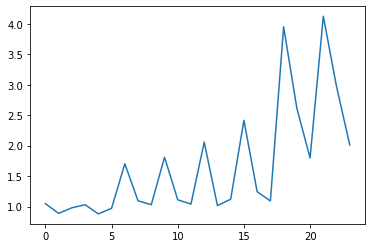

In [72]:
# plt.figure(figsize=(15,10))
plt.plot(np.max(recovery_rate[:], axis=1))

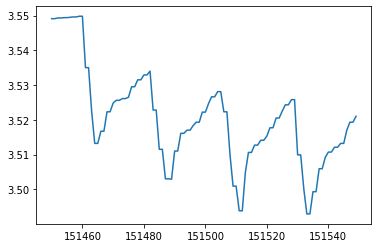

In [22]:
# plt.figure(figsize=(15,10))
plt.plot(data['Voltage(V)'][151450:151550])

In [27]:
re_time = np.array([])
for i in recovery_time:
    re_time = np.append(re_time, np.array((i[1]-i[0]).seconds))

In [24]:
re_time2 = re_time

In [32]:
np.average(re_time2 - re_time)

4.5

In [62]:
index[6]

array([519372., 519549.])

In [66]:
data['Time'][519372]

'2021-12-10 오전 4:26:54'

In [63]:
recovery_volt[6]

array([3.5213, 3.3822, 3.5042])

In [64]:
recovery_rate[6]

array([3.95024565, 0.48561611])

In [65]:
recovery_time[6]

array([datetime.datetime(2021, 12, 10, 4, 27, 18),
       datetime.datetime(2021, 12, 10, 4, 27, 42)], dtype=object)

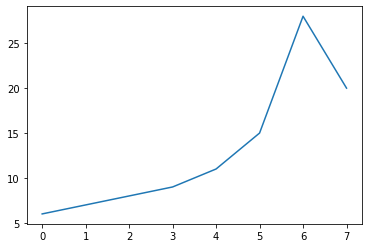

In [20]:
plt.plot(re_time) #통신 중 ~ 회복 전압

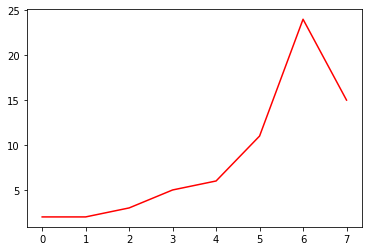

In [51]:
plt.plot(re_time, c="r") #통신 끝 ~ 회복 전압

In [18]:
mAh = np.array([], dtype=int)
current = 0

for i in tqdm(range(int(len(ref)/2))):
    current += 3800
    cap = current / 3600
    mAh = np.append(mAh, np.array(cap))

100%|████████████████████████████████████████████████████████████████████| 5266/5266 [00:00<00:00, 158923.62it/s]


In [19]:
mAh_ = mAh/8500 * 100 #21158

In [20]:
cap

5558.555555555556

In [21]:
mAh_[-1]

65.39477124183006

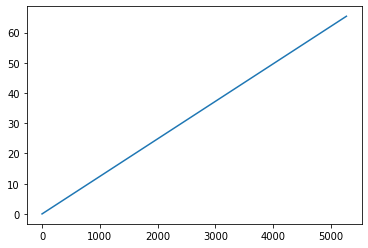

In [22]:
plt.plot(mAh_)

#### 전압 회복 시간 계산

In [25]:
re_time = np.array([])
for i in recovery_time:
    re_time = np.append(re_time, np.array((i[1]-i[0]).seconds))

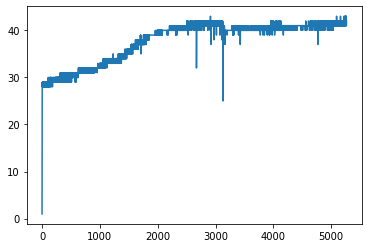

In [27]:
plt.plot(re_time) #통신 끝 ~ 회복 전압

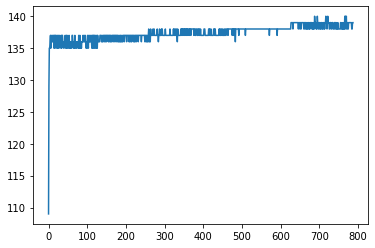

In [223]:
plt.plot(re_time) #기준 전압 ~ 회복 전압

*평균 전압 회복 시간*

In [224]:
np.average(re_time)

137.35152284263958

In [262]:
np.average(re_time)

29.911167512690355

#### 전압 회복 시간, 최대 전압 변화율 파일로 저장

In [185]:
max_rate = np.max(recovery_rate[:], axis=1)

In [204]:
f = open("NORMAL+EDLC(0-100-40).csv", "w")
f.write("recovery_time(s), max_rate\n")

for i in range(int(len(max_rate))):
    f.write(str(re_time[i]) + ", " + str(max_rate[i]) + "\n")
    
f.close()

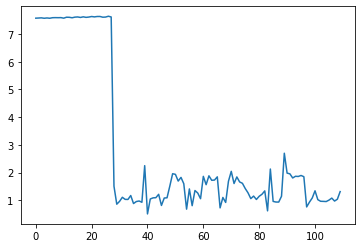

In [146]:
plt.plot(np.max(recovery_rate[600:], axis=1)) #627